# 10_1.Two-Way mixed ANOVA
- https://pingouin-stats.org/build/html/generated/pingouin.mixed_anova.html#pingouin.mixed_anova

## 1.기본 package 설정

In [ ]:
# 그래프에서 한글 폰트 인식하기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install pingouin

#  *** 런타임 다시 시작

In [1]:
# 1.기본
import numpy as np  # numpy 패키지 가져오기
import matplotlib.pyplot as plt # 시각화 패키지 가져오기
import seaborn as sns # 시각화

# 2.데이터 가져오기
import pandas as pd # csv -> dataframe으로 전환

# 3.통계분석 package
import pingouin as pg
from scipy import stats
import statsmodels.api as sm

In [2]:
# 기본세팅
# 테마 설정
sns.set_theme(style = "darkgrid")

# 한글 인식
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # -인식

## 2.데이터 불러오기

### 2.1 데이터 프레임으로 저장
- 원본데이터(csv)를 dataframe 형태로 가져오기(pandas)

In [3]:
twma_df = pd.read_csv('https://raw.githubusercontent.com/leecho-bigdata/statistics-python/main/10_1.TWMA.csv', encoding="cp949")
twma_df.head()

,id,실험그룹,시점,통증1,통증2,통증3
0,1,1,1,12.32,12.32,12.32
1,2,1,1,57.16,57.16,57.16
2,3,1,1,12.32,12.32,12.32
3,4,1,1,16.62,16.62,16.62
4,5,1,1,18.63,18.63,18.63


### 2.2 범주형 변수 처리
- 가변수 처리시 문자로 처리를 해야 변수명 구분이 쉬움

In [4]:
twma_df['실험그룹'].replace({1:'대조군', 2:'실험군'}, inplace=True)
twma_df['시점'].replace({1:'사전', 2:'사후'}, inplace=True)
twma_df['실험그룹'] = twma_df['실험그룹'].astype('category')
twma_df['시점'] = twma_df['시점'].astype('category')

twma_df.head()

,id,실험그룹,시점,통증1,통증2,통증3
0,1,대조군,사전,12.32,12.32,12.32
1,2,대조군,사전,57.16,57.16,57.16
2,3,대조군,사전,12.32,12.32,12.32
3,4,대조군,사전,16.62,16.62,16.62
4,5,대조군,사전,18.63,18.63,18.63


### 2.3 자료구조 살펴보기

In [5]:
twma_df.shape

(254, 6)

In [6]:
twma_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   id      254 non-null    int64   
 1   실험그룹    254 non-null    category
 2   시점      254 non-null    category
 3   통증1     254 non-null    float64 
 4   통증2     254 non-null    float64 
 5   통증3     254 non-null    float64 
dtypes: category(2), float64(3), int64(1)
memory usage: 8.8 KB


In [7]:
twma_df.columns

Index(['id', '실험그룹', '시점', '통증1', '통증2', '통증3'], dtype='object')

## 3.기술통계

In [8]:
# 그룹별 기술통계
twma_df.groupby(["실험그룹","시점"])["통증1"].describe().round(3)

count    mean     std    min    25%    50%     75%    max
실험그룹 시점                                                           
대조군  사전   58.0  41.914  14.640  12.32  33.54  41.39  49.933  73.05
     사후   58.0  41.458   9.496  21.54  36.22  42.07  49.260  57.53
실험군  사전   69.0  41.639  16.141   5.08  31.22  42.45  51.150  72.57
     사후   69.0  32.782  10.085  10.80  25.42  32.62  38.820  54.58

In [9]:
# 분석변수가 여러개 일 때
num_feature = ['통증1', '통증2', '통증3']
for num in num_feature:
    print("----", num, "----")
    results = twma_df.groupby(["실험그룹","시점"])[num].describe().round(3)
    print(results, "\n")

---- 통증1 ----
         count    mean     std    min    25%    50%     75%    max
실험그룹 시점                                                           
대조군  사전   58.0  41.914  14.640  12.32  33.54  41.39  49.933  73.05
     사후   58.0  41.458   9.496  21.54  36.22  42.07  49.260  57.53
실험군  사전   69.0  41.639  16.141   5.08  31.22  42.45  51.150  72.57
     사후   69.0  32.782  10.085  10.80  25.42  32.62  38.820  54.58 

---- 통증2 ----
         count    mean     std    min    25%    50%     75%    max
실험그룹 시점                                                           
대조군  사전   58.0  41.914  14.640  12.32  33.54  41.39  49.933  73.05
     사후   58.0  40.458   9.496  20.54  35.22  41.07  48.260  56.53
실험군  사전   69.0  41.639  16.141   5.08  31.22  42.45  51.150  72.57
     사후   69.0  39.782  10.085  17.80  32.42  39.62  45.820  61.58 

---- 통증3 ----
         count    mean     std    min    25%    50%     75%    max
실험그룹 시점                                                           
대조군  사전   58.0  

## 4.TWM-ANOVA

### 4.1 상호작용효과 있을때

In [10]:
# 상호작용효과 있을때,
# 구형성일때: correction = False
pg.mixed_anova(dv = '통증1',
               between = "실험그룹",
               within = "시점",
               subject='id',
               correction = False,
               data = twma_df).round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,실험그룹,1262.254,1,125,1262.254,4.666,0.033,0.036,NaN
1,시점,1600.527,1,125,1600.527,24.479,0.000,0.164,1.0
2,Interaction,1112.226,1,125,1112.226,17.011,0.000,0.120,NaN


In [11]:
# 시점이 2개일때는 구형성 없음
pg.sphericity(dv = '통증1',
              within = '시점',
              subject = "id",
              data = twma_df)

(True, nan, nan, 1, 1.0)

In [12]:
# post-hoc test: 상호작용효과 있을때
pg.pairwise_tests(dv = '통증1',
                  between = "실험그룹",
                  within = "시점",
                  subject='id',
                  data = twma_df).round(3)

,Contrast,시점,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,시점,-,사전,사후,True,True,4.660,126.000,two-sided,0.000,1811.627,0.377
1,실험그룹,-,대조군,실험군,False,True,2.205,124.470,two-sided,0.029,1.685,0.382
2,시점 * 실험그룹,사전,대조군,실험군,False,True,0.100,124.254,two-sided,0.920,0.191,0.018
3,시점 * 실험그룹,사후,대조군,실험군,False,True,4.985,123.368,two-sided,0.000,7393.895,0.878


In [13]:
# post-hoc test: 상호작용효과 있을때
# within_first = False: 실험그룹 * 시점
pg.pairwise_tests(dv = '통증1',
                  between = "실험그룹",
                  within = "시점",
                  subject = 'id',
                  within_first = False,
                  data = twma_df).round(3)

,Contrast,실험그룹,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,실험그룹,-,대조군,실험군,False,True,2.205,124.47,two-sided,0.029,1.685,0.382
1,시점,-,사전,사후,True,True,4.660,126.00,two-sided,0.000,1811.627,0.377
2,실험그룹 * 시점,대조군,사전,사후,True,True,0.243,57.00,two-sided,0.809,0.148,0.037
3,실험그룹 * 시점,실험군,사전,사후,True,True,8.849,68.00,two-sided,0.000,1.277e+10,0.654


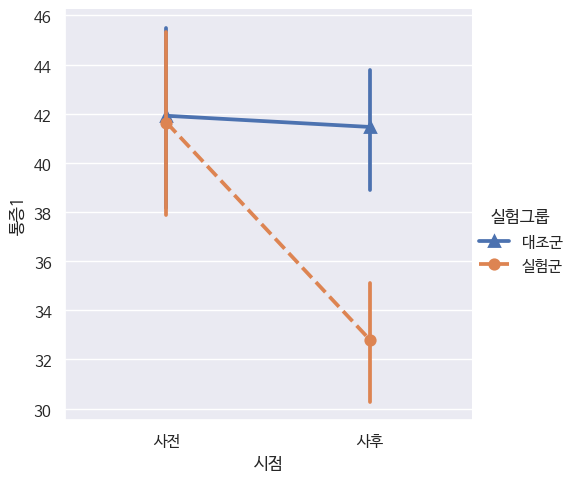

In [14]:
# 평균반응 프로파일 plot
sns.catplot(x = "시점",
            y = "통증1",
            hue = "실험그룹",
            markers = ["^", "o"],
            linestyles = ["-", "--"],
            kind = "point",
            data = twma_df)
plt.show()

### 4.2 상호작용효과 없을때, 그룹,시점 모두 의미없을때

In [15]:
# 상호작용효과 없을때, 그룹,시점 모두 의미없을때
# 구형성일때: correction = False
pg.mixed_anova(dv = '통증2',
               between = "실험그룹",
               within = "시점",
               subject='id',
               correction = False,
               data = twma_df).round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,실험그룹,14.237,1,125,14.237,0.053,0.819,0.000,NaN
1,시점,177.948,1,125,177.948,2.722,0.102,0.021,1.0
2,Interaction,2.544,1,125,2.544,0.039,0.844,0.000,NaN


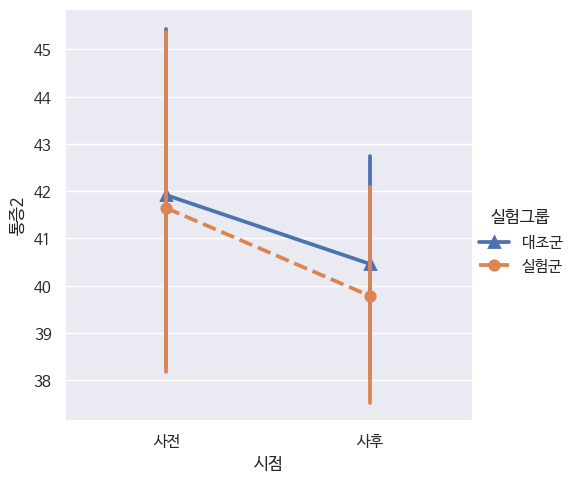

In [16]:
# 평균반응 프로파일 plot
sns.catplot(x = "시점",
            y = "통증2",
            hue = "실험그룹",
            markers = ["^", "o"],
            linestyles = ["-", "--"],
            kind = "point",
            data = twma_df)
plt.show()

### 4.3 상호작용효과 없을때, 시점만 의미 있을때

In [17]:
# 상호작용효과 없을때, 시점만 의미 있을때
# 구형성일때: correction = False
pg.mixed_anova(dv = '통증3',
               between = "실험그룹",
               within = "시점",
               subject='id',
               correction = False,
               data = twma_df).round(3)

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,실험그룹,0.038,1,125,0.038,0.000,0.991,0.000,NaN
1,시점,1083.485,1,125,1083.485,16.571,0.000,0.117,1.0
2,Interaction,5.637,1,125,5.637,0.086,0.770,0.001,NaN


In [18]:
# 시점이 2개일때는 구형성 없음
pg.sphericity(dv = '통증3',
              within = '시점',
              subject = "id",
              data = twma_df)

(True, nan, nan, 1, 1.0)

In [19]:
# post-hoc test: 상호작용효과 없을때
# interaction = False
pg.pairwise_tests(dv = '통증3',
                  between = "실험그룹",
                  within = "시점",
                  subject='id',
                  interaction = False,
                  data = twma_df).round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,시점,사전,사후,True,True,4.086,126.00,two-sided,0.00,213.155,0.319
1,실험그룹,대조군,실험군,False,True,-0.012,124.47,two-sided,0.99,0.19,-0.002


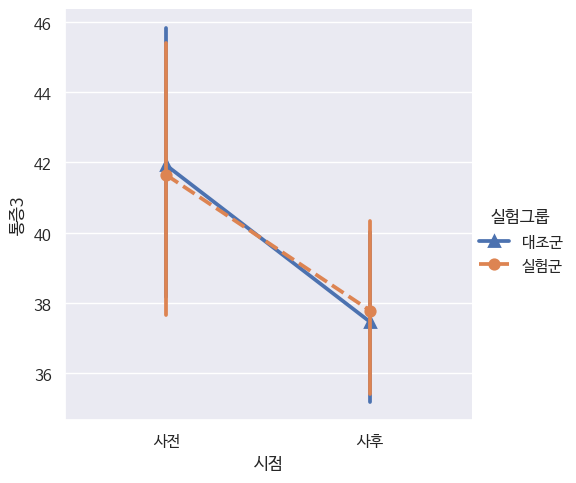

In [20]:
# 평균반응 프로파일 plot
sns.catplot(x = "시점",
            y = "통증3",
            hue = "실험그룹",
            markers = ["^", "o"],
            linestyles = ["-", "--"],
            kind = "point",
            data = twma_df)
plt.show()